In [21]:
using CSV, DataFrames, Statistics, LinearAlgebra, Dates, Gadfly, Colors, StatsBase
using Interpolations


In [2]:
function rmse(predicted, target)
    differences = predicted - target                 
    differences_squared = differences .^ 2                    
    mean_of_differences_squared = mean(differences_squared)  
    rmse_val = sqrt(mean_of_differences_squared)     
    return rmse_val
    
end

rmse (generic function with 1 method)

In [3]:
train = CSV.read("stock_data.csv")
head(train)

┌ Warning: `head(df::AbstractDataFrame)` is deprecated, use `first(df, 6)` instead.
│   caller = top-level scope at In[3]:2
└ @ Core In[3]:2


,quarter,stock,date,open,high,low,close,volume,change
,Int64,String,Date,Float64,Float64,Float64,Float64⍰,Int64,Float64⍰
1,1,AA,2011-01-07,15.82,16.72,15.78,16.42,239655616,3.79267
2,1,AA,2011-01-14,16.71,16.71,15.64,15.97,242963398,-4.42849
3,1,AA,2011-01-21,16.19,16.38,15.6,15.79,138428495,-2.47066
4,1,AA,2011-01-28,15.87,16.63,15.82,16.13,151379173,1.63831
5,1,AA,2011-02-04,16.18,17.39,16.18,17.14,154387761,5.93325
6,1,AA,2011-02-11,17.33,17.48,16.97,17.37,114691279,0.230814


In [6]:
mcd = groupby(train, :stock)[(stock="MCD",)]
dis = groupby(train, :stock)[(stock="DIS",)]

,quarter,stock,date,open,high,low,close,volume,change
,Int64,String,Date,Float64,Float64,Float64,Float64⍰,Int64,Float64⍰
1,1,DIS,2011-01-07,37.74,40.0,37.62,39.45,72917621,4.531
2,1,DIS,2011-01-14,39.01,39.81,38.92,39.29,31943413,0.717765
3,1,DIS,2011-01-21,39.07,39.94,38.51,missing,36187032,missing
4,1,DIS,2011-01-28,39.64,39.95,38.65,38.85,42131642,-1.99294
5,1,DIS,2011-02-04,39.04,40.77,38.64,40.71,53521486,4.27766
6,1,DIS,2011-02-11,40.8,44.05,40.71,43.41,83975520,6.39706
7,1,DIS,2011-02-18,43.19,43.9,42.98,43.56,33868302,0.85668
8,1,DIS,2011-02-25,42.83,43.28,41.6,missing,56966763,missing
9,1,DIS,2011-03-04,43.02,44.34,42.97,43.55,53096584,1.23199


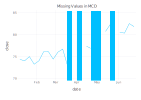

In [7]:
mcd_missing = filter(row -> ismissing(row[:close]) == true, mcd) #get missing dataframe
mcd_missing[:,:start_date] .= mcd_missing[:,:date] - Dates.Day(7)

plot(mcd, x=:date, y=:close, Geom.line, 
    layer(mcd_missing, xmin=:start_date , xmax=:date, Geom.vband),  
    Guide.title("Missing Values in MCD"),

    )


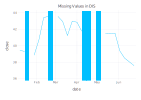

In [8]:
dis_missing = filter(row -> ismissing(row[:close]) == true, dis) #get missing dataframe
dis_missing[:,:start_date] .= dis_missing[:,:date] - Dates.Day(7)

plot(dis, x=:date, y=:close, Geom.line, 
    layer(dis_missing, xmin=:start_date , xmax=:date, Geom.vband),  
    Guide.title("Missing Values in DIS"),

    )

In [9]:
y_dis = dropmissing(dis)[!, :close]
println("mean: ", mean(y_dis))         
println("variance: ", var(y_dis))      


mean: 41.084999999999994
variance: 3.94446842105263


In [10]:
y_mcd = dropmissing(mcd)[!, :close]
println("mean: ", mean(y_mcd))         
println("variance: ", var(y_mcd))     

mean: 77.092
variance: 9.911711578947369


Will try to fill in the missing data, via common timeseries imputation method, for that we will take the stock that is most correlated with mcd,dis, introduce missing values in the same locaiton as our original series
compute the rmse of the fit

# DIS BA Pair

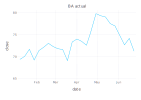

In [12]:
ba_actual = groupby(train, :stock)[(stock="BA",)]
ba_actual = select(ba_actual, [:date, :close])
plot(ba_actual, x=:date, y=:close, Geom.line, Guide.title("BA actual"))


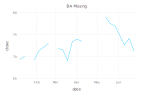

In [14]:
ba_missing = copy(ba_actual);
allowmissing!(ba_missing) 
ba_missing.close[3] = missing
ba_missing.close[8] = missing
ba_missing.close[15] = missing
ba_missing.close[16] = missing
ba_missing.close[18] = missing

plot(ba_missing, x=:date, y=:close, Geom.line, Guide.title("BA Missing"))


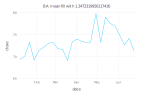

In [15]:
## mean fill 
ba_mean = copy(ba_missing)
recode!(ba_mean[!, :close], missing => mean(skipmissing(ba_mean[!, :close])));
rmse_error = rmse(ba_mean[!, :close], ba_actual[!, :close])
plot(ba_mean, x=:date, y=:close, Geom.line, Guide.title("BA mean fill with $rmse_error "))


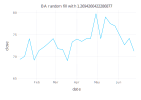

In [16]:
## random fill 
ba_random = copy(ba_missing)
max_ba= maximum(dropmissing(ba_missing)[!, :close])
min_ba = minimum(dropmissing(ba_missing)[!, :close])

recode!(ba_random[!, :close], missing => rand(min_ba:max_ba))
rmse_error = rmse(ba_random[!, :close], ba_actual[!, :close])
plot(ba_random, x=:date, y=:close, Geom.line, Guide.title("BA random fill with $rmse_error "))


In [22]:
## linear interpolation 

ba_interpolation = copy(ba_missing)
ba_interpolation_ = copy(ba_missing)
ba_interpolation = hcat(ba_interpolation, collect(1:size(ba_interpolation,1))); #this will be have as our x
ba_interpolation= dropmissing(ba_interpolation)
itp = LinearInterpolation(ba_interpolation[!, :x1], ba_interpolation[!, :close],extrapolation_bc=Flat());



In [23]:
dates = filter(row -> ismissing(row[:close]) == true, ba_interpolation_)[:, :date]

for date in dates
   ind = findfirst(ba_interpolation_[:,:date] .== date)
    ba_interpolation_[ind, :][:close] = itp(ind)
end



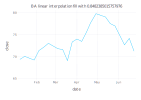

In [24]:
rmse_error = rmse(ba_interpolation_[!, :close], ba_actual[!, :close])
plot(ba_interpolation_, x=:date, y=:close, Geom.line, Guide.title("BA linear interpolation fill with $rmse_error "))

┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = top-level scope at In[25]:10
└ @ Core ./In[25]:10


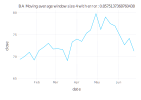

In [25]:
# rolling mean fill aka. Moving average


ba_ma = copy(ba_missing)
windowsize= 4 # it will calculate the mean from the missing value +- windowsize
dates = filter(row -> ismissing(row[:close]) == true, ba_ma)[:, :date]

for date in dates
   ind = findfirst(ba_ma[:,:date] .== date)
   ba_ma[ind, :][:close]  =  mean(dropmissing(ba_ma)[range(max(ind - windowsize, 1), ind + windowsize),:close]) # taking the max because I cant have zero index
end


rmse_error = rmse(ba_ma[!, :close], ba_actual[!, :close])
plot(ba_ma, x=:date, y=:close, Geom.line, Guide.title("BA Moving average window size $windowsize  with error: $rmse_error "))



# MCD KO Pair

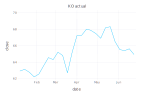

In [26]:
ko_actual = groupby(train, :stock)[(stock="KO",)]
ko_actual = select(ko_actual, [:date, :close])
plot(ko_actual, x=:date, y=:close, Geom.line, Guide.title("KO actual"))


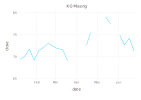

In [27]:
ko_missing = copy(ba_actual);
allowmissing!(ko_missing) 
ko_missing.close[12] = missing
ko_missing.close[14] = missing
ko_missing.close[17] = missing
ko_missing.close[18] = missing
ko_missing.close[21] = missing

plot(ko_missing, x=:date, y=:close, Geom.line, Guide.title("KO Missing"))


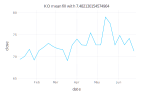

In [31]:
## mean fill 
ko_mean = copy(ko_missing)
recode!(ko_mean[!, :close], missing => mean(skipmissing(ko_mean[!, :close])));
rmse_error = rmse(ko_mean[!, :close], ko_actual[!, :close])
plot(ko_mean, x=:date, y=:close, Geom.line, Guide.title("KO mean fill with $rmse_error "))


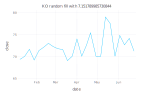

In [32]:
## random fill 
ko_random = copy(ko_missing)
max_ko= maximum(dropmissing(ko_missing)[!, :close])
min_ko = minimum(dropmissing(ko_missing)[!, :close])

recode!(ko_random[!, :close], missing => rand(min_ko:max_ko))
rmse_error = rmse(ko_random[!, :close], ko_actual[!, :close])
plot(ko_random, x=:date, y=:close, Geom.line, Guide.title("KO random fill with $rmse_error "))


In [34]:
## linear interpolation 

ko_interpolation = copy(ko_missing)
ko_interpolation_ = copy(ko_missing)
ko_interpolation = hcat(ko_interpolation, collect(1:size(ko_interpolation,1))); #this will be have as our x
ko_interpolation = dropmissing(ba_interpolation)
itp = LinearInterpolation(ko_interpolation[!, :x1], ko_interpolation[!, :close],extrapolation_bc=Flat());



In [35]:
dates = filter(row -> ismissing(row[:close]) == true, ko_interpolation_)[:, :date]

for date in dates
   ind = findfirst(ko_interpolation_[:,:date] .== date)
    ko_interpolation_[ind, :][:close] = itp(ind)
end



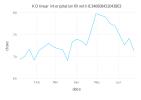

In [36]:
rmse_error = rmse(ko_interpolation_[!, :close], ko_actual[!, :close])
plot(ko_interpolation_, x=:date, y=:close, Geom.line, Guide.title("KO linear interpolation fill with $rmse_error "))

┌ Warning: `range(start, stop)` (with neither `length` nor `step` given) is deprecated, use `range(start, stop=stop)` instead.
│   caller = top-level scope at In[48]:10
└ @ Core ./In[48]:10


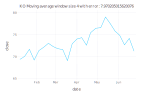

In [48]:
# rolling mean fill aka. Moving average


ko_ma = copy(ko_missing)
windowsize= 4 # it will calculate the mean from the missing value +- windowsize
dates = filter(row -> ismissing(row[:close]) == true, ko_ma)[:, :date]

for date in dates
   ind = findfirst(ko_ma[:,:date] .== date)
   ko_ma[ind, :][:close]  =  mean(dropmissing(ba_ma)[range(max(ind - windowsize, 1), ind + windowsize),:close]) # taking the max because I cant have zero index
end


rmse_error = rmse(ko_ma[!, :close], ko_actual[!, :close])
plot(ko_ma, x=:date, y=:close, Geom.line, Guide.title("KO Moving average window size $windowsize  with error: $rmse_error "))



The mcd/ko pair is having a high rmse error, because the missing data fall in the same place, therefore increasing the uncerctainty in the direction of the time series, that's why this method won't work and we need to use our explantory variable to get more certainity.